#GraphSage

#import

In [1]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

In [2]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 54.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 30.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 885.2/885.2 kB 12.3 MB/s eta 0:00:00
Looking in indexes: 

In [3]:
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive
!pip install ogb #needed for the dataset

  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=02f054d603169612faa1d4e5084baa00d5160280d4c86f6fca9aeae97709690d
  Stored in directory: /root/.cache/pip/wheels/04/bb/0d/2d02ec45f29c48d6192476bfb59c5a0e64b605e7212374dd15
Successfully built littleutils


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.data import DataLoader
from torch_geometric.utils import negative_sampling
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator #needed to extract and evaluate the ogb-ddi dataset
import matplotlib.pyplot as plt #needed to visualize loss curves
import numpy as np 
from tqdm import tqdm

#Model

In [5]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, emb=False):
        super(GNNStack, self).__init__()
        conv_model = pyg.nn.SAGEConv

        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        self.dropout = dropout
        self.num_layers = num_layers
        self.emb = emb

        assert (self.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(self.num_layers - 1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(self.dropout),
            nn.Linear(hidden_dim, output_dim))

    def forward(self, x, edge_index):
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.post_mp(x)

        # Return node embeddings after post-message passing if specified
        return x

class LinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        # Create linear layers
        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        # x_i and x_j are both of shape (E, D)  
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)
        

#Data

In [6]:
import networkx as nx
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
def load_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        user_id, friends = row["user_id"], eval(row["friends"])
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)
    
    return edges

def load_test_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    scores = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        edges.append((row["src"], row["dst"]))
        scores.append(row["score"])
    #edges = sorted(edges)
    
    return edges,scores

def generate_false_edges(true_edges, num_false_edges=5):
    """
    generate false edges given true edges
    """
    nodes = list(set(chain.from_iterable(true_edges)))
    N = len(nodes)
    true_edges = set(true_edges)
    print(N, len(true_edges))
    false_edges = set()
    
    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        src, dst = nodes[int(np.random.rand() * N)], nodes[int(np.random.rand() * N)]
        if src != dst and (src, dst) not in true_edges and (src, dst) not in false_edges:
            false_edges.add((src, dst))
    false_edges = sorted(false_edges)
    
    return false_edges

def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))
        
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(weighed_edge_list)
    
    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())
    
    return graph

In [9]:
#For Testing Purpose
from numpy.random import default_rng
rng = default_rng()
numbers = rng.choice(100000, size=20000, replace=False)
numbers

array([43986, 33769, 22947, ..., 60276, 52220, 82726])

In [10]:
#Load data
train_file = "/content/drive/MyDrive/4332/Project2/data/train.csv"
valid_file = "/content/drive/MyDrive/4332/Project2/data/valid.csv"
test_file = "/content/drive/MyDrive/4332/Project2/data/test.csv"

np.random.seed(2023)
train_pos_edges = load_data(train_file)

#Testing
'''
temp_train, valid_pos_edges = [],[]
for i in range(100000):
  if i in numbers:
    valid_pos_edges.append(train_pos_edges[i])
  else:
    temp_train.append(train_pos_edges[i])
train_pos_edges = temp_train
'''
valid_pos_edges = load_data(valid_file)


train_neg_edges = generate_false_edges(train_pos_edges, 100000)
valid_neg_edges = generate_false_edges(train_pos_edges+valid_pos_edges, 40000-len(valid_pos_edges))
test_edges,test_scores = load_test_data(test_file)
#test_edges = []

8334 100000
8485 119267


In [11]:
#Get dictionary idx_node (key: node name, value: index)
g_tmp_v = construct_graph_from_edges(train_pos_edges)
idx_node = {n:idx for idx, n in enumerate(list(g_tmp_v.nodes))}

number of nodes: 8334
number of edges: 100000


In [12]:
#tranform training data to torch tensor
pos_train_edge = torch.zeros(100000,2)
pos_edge_index = torch.zeros(2,100000)
neg_train_edge = torch.zeros(100000, 2)
neg_edge_index = torch.zeros(2,100000)

for idx,tp in enumerate(train_pos_edges):
  idx1, idx2 = idx_node[tp[0]], idx_node[tp[1]]
  pos_train_edge[idx][0], pos_train_edge[idx][1] = idx1, idx2
  pos_edge_index[0][idx], pos_edge_index[1][idx] = idx1, idx2

for idx,tp in enumerate(train_neg_edges):
  idx1, idx2 = idx_node[tp[0]], idx_node[tp[1]]
  neg_train_edge[idx][0], neg_train_edge[idx][1] = idx1, idx2
  neg_edge_index[0][idx], neg_edge_index[1][idx] = idx1, idx2

In [13]:
#put to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pos_train_edge = pos_train_edge.type(torch.int64).to(device)
pos_edge_index = pos_edge_index.type(torch.int64).to(device)
neg_train_edge = neg_train_edge.type(torch.int64).to(device)
neg_edge_index = neg_edge_index.type(torch.int64).to(device)

In [15]:
#tranform validation data to torch tensor
pos_valid_edge = torch.zeros(len(valid_pos_edges), 2)
neg_valid_edge = torch.zeros(len(valid_neg_edges), 2)
fail = 0
for idx,tp in enumerate(valid_pos_edges):
  try:
    idx1, idx2 = idx_node[tp[0]], idx_node[tp[1]]
  except:
    idx1, idx2 = 30000,30000
    fail += 1
  pos_valid_edge[idx][0], pos_valid_edge[idx][1] = idx1, idx2
for idx,tp in enumerate(valid_neg_edges):
  try:
    idx1, idx2 = idx_node[tp[0]], idx_node[tp[1]]
  except:
    idx1, idx2 = 30000,30000
    fail += 1
  neg_valid_edge[idx][0], neg_valid_edge[idx][1] = idx1, idx2
print(fail)

963


In [16]:
#put to cuda
pos_valid_edge = pos_valid_edge.type(torch.int64).to(device)
neg_valid_edge = neg_valid_edge.type(torch.int64).to(device)

#Train

In [17]:
def train(model, link_predictor, emb, pos_edge_index, pos_train_edge, neg_train_edge, batch_size, optimizer):
    model.train()
    link_predictor.train()

    train_losses = []

    for edge_id in DataLoader(range(pos_train_edge.shape[0]), batch_size, shuffle=True):
      
        optimizer.zero_grad()

        # Run message passing on the inital node embeddings to get updated embeddings
        node_emb = model(emb, pos_edge_index)  # (N, d)

        # Predict the class probabilities on the batch of positive edges using link_predictor
        pos_edge = pos_train_edge[edge_id].T  # (2, B)
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])  # (B, )

        # Sample negative edges (same number as number of positive edges) and predict class probabilities 
        neg_edge = neg_train_edge[edge_id].T
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])  # (Ne,)

        # Compute the corresponding negative log likelihood loss on the positive and negative edges
        loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()

        # Backpropagate and update parameters
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
    return sum(train_losses) / len(train_losses)

In [18]:
def test(model, predictor, emb, pos_edge_index, pos_valid_edge, neg_valid_edge, batch_size, mode="train"):
    model.eval()
    predictor.eval()

    node_emb = model(emb, pos_edge_index)

    pos_valid_preds = []
    fail = 0
    for edge_id in tqdm(DataLoader(range(pos_valid_edge.shape[0]), batch_size)):
        pos_edge = pos_valid_edge[edge_id].T

        if mode == "test":
            if pos_edge[0] == 30000 or pos_edge[1] == 30000:
                pos_valid_preds.append(0.5)
                fail += 1
            else:
                pos_valid_preds.append(predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]]).item())
        else:
            pos_valid_preds += [predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]]).squeeze().cpu()]

    neg_valid_preds = []
    for edge_id in tqdm(DataLoader(range(neg_valid_edge.shape[0]), batch_size)):
        neg_edge = neg_valid_edge[edge_id].T
        
        if mode == "test":
            if neg_edge[0] == 30000 or neg_edge[1] == 30000:
                neg_valid_preds.append(0.5)
                fail += 1
            else:
                neg_valid_preds.append(predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]]).item())
        else:
            neg_valid_preds += [predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]]).squeeze().cpu()]

    if mode == "test":
        pos_valid_pred = pos_valid_preds
        neg_valid_pred = neg_valid_preds
    else:
        pos_valid_pred = torch.cat(pos_valid_preds, dim=0)
        neg_valid_pred = torch.cat(neg_valid_preds, dim=0)
    
    print("fail: ", fail)

    y_true = [1] * len(pos_valid_pred) + [0] * len(neg_valid_pred)
    
    if mode == "test":
        y_score = pos_valid_pred + neg_valid_pred
    else:
        y_score = list(pos_valid_pred.detach().cpu().numpy()) + list(neg_valid_pred.detach().cpu().numpy())
    
    return roc_auc_score(y_true, y_score)


In [19]:
# Hyperparameters
from torch.optim.lr_scheduler import CosineAnnealingLR
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optim_wd = 0
epochs = 1000
hidden_dim = 64
dropout = 0.3
num_layers = 3
lr = 1e-3
node_emb_dim = 10
batch_size = 25000

/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 4/4 [00:00<00:00, 97.30it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
19 training acc: 0.9247986115


100%|██████████| 4/4 [00:00<00:00, 100.09it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
39 training acc: 0.95133109215


100%|██████████| 4/4 [00:00<00:00, 102.66it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
59 training acc: 0.9558775229


100%|██████████| 4/4 [00:00<00:00, 48.51it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
79 training acc: 0.9594692948499999


100%|██████████| 4/4 [00:00<00:00, 40.78it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
99 training acc: 0.9636136119999998


100%|██████████| 4/4 [00:00<00:00, 98.89it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
119 training acc: 0.9716278661500001


100%|██████████| 4/4 [00:00<00:00, 96.23it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
139 training acc: 0.9760917254000001


100%|██████████| 4/4 [00:00<00:00, 100.31it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
159 training acc: 0.978702916


100%|██████████| 4/4 [00:00<00:00, 92.02it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
179 training acc: 0.9804439941


100%|██████████| 4/4 [00:00<00:00, 104.85it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
199 training acc: 0.9813112934499999


100%|██████████| 4/4 [00:00<00:00, 51.93it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
219 training acc: 0.98232229505


100%|██████████| 4/4 [00:00<00:00, 28.21it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
239 training acc: 0.9831452955


100%|██████████| 4/4 [00:00<00:00, 107.74it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
259 training acc: 0.9836704986000002


100%|██████████| 4/4 [00:00<00:00, 104.44it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
279 training acc: 0.98448506585


100%|██████████| 4/4 [00:00<00:00, 92.55it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
299 training acc: 0.9852133703500001


100%|██████████| 4/4 [00:00<00:00, 100.43it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
319 training acc: 0.98570916675


100%|██████████| 4/4 [00:00<00:00, 102.40it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
339 training acc: 0.9864874107000001


100%|██████████| 4/4 [00:00<00:00, 45.21it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
359 training acc: 0.9873975320000001


100%|██████████| 4/4 [00:00<00:00, 55.73it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
379 training acc: 0.9878653767


100%|██████████| 4/4 [00:00<00:00, 97.24it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
399 training acc: 0.9886620100000001


100%|██████████| 4/4 [00:00<00:00, 106.28it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
419 training acc: 0.98923068955


100%|██████████| 4/4 [00:00<00:00, 100.87it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
439 training acc: 0.9895482648


100%|██████████| 4/4 [00:00<00:00, 99.18it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
459 training acc: 0.989873601


100%|██████████| 4/4 [00:00<00:00, 42.50it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
479 training acc: 0.9900262248999999


100%|██████████| 4/4 [00:00<00:00, 52.53it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
499 training acc: 0.99024926125


100%|██████████| 4/4 [00:00<00:00, 101.05it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
519 training acc: 0.990382556


100%|██████████| 4/4 [00:00<00:00, 100.66it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
539 training acc: 0.99053527995


100%|██████████| 4/4 [00:00<00:00, 95.48it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
559 training acc: 0.99072112685


100%|██████████| 4/4 [00:00<00:00, 94.67it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
579 training acc: 0.9908087964500001


100%|██████████| 4/4 [00:00<00:00, 73.20it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
599 training acc: 0.99085715735


100%|██████████| 4/4 [00:00<00:00, 51.58it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
619 training acc: 0.9909861081


100%|██████████| 4/4 [00:00<00:00, 48.51it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
639 training acc: 0.9910941347


100%|██████████| 4/4 [00:00<00:00, 101.41it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
659 training acc: 0.9911514965499999


100%|██████████| 4/4 [00:00<00:00, 96.76it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
679 training acc: 0.9911580956500002


100%|██████████| 4/4 [00:00<00:00, 101.30it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
699 training acc: 0.9912037547500001


100%|██████████| 4/4 [00:00<00:00, 97.45it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
719 training acc: 0.9913002507


100%|██████████| 4/4 [00:00<00:00, 102.07it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
739 training acc: 0.99136056695


100%|██████████| 4/4 [00:00<00:00, 58.52it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
759 training acc: 0.9913024065999999


100%|██████████| 4/4 [00:00<00:00, 51.33it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
779 training acc: 0.9913759310000001


100%|██████████| 4/4 [00:00<00:00, 102.21it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
799 training acc: 0.9914008697


100%|██████████| 4/4 [00:00<00:00, 89.79it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
819 training acc: 0.99141902965


100%|██████████| 4/4 [00:00<00:00, 98.85it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
839 training acc: 0.9914434518999998


100%|██████████| 4/4 [00:00<00:00, 99.72it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
859 training acc: 0.99147956275


100%|██████████| 4/4 [00:00<00:00, 93.81it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
879 training acc: 0.99147837335


100%|██████████| 4/4 [00:00<00:00, 104.13it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
899 training acc: 0.9914829857999999


100%|██████████| 4/4 [00:00<00:00, 48.04it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
919 training acc: 0.9914733285499999


100%|██████████| 4/4 [00:00<00:00, 97.33it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
939 training acc: 0.9914993852499999


100%|██████████| 4/4 [00:00<00:00, 101.23it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
959 training acc: 0.9915018130500001


100%|██████████| 4/4 [00:00<00:00, 99.34it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
979 training acc: 0.9915028990999999


100%|██████████| 4/4 [00:00<00:00, 89.79it/s]
/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


fail:  0
999 training acc: 0.9915021418999999


100%|██████████| 20733/20733 [00:15<00:00, 1380.70it/s]


fail:  963
validation acc:  0.9803864458828048


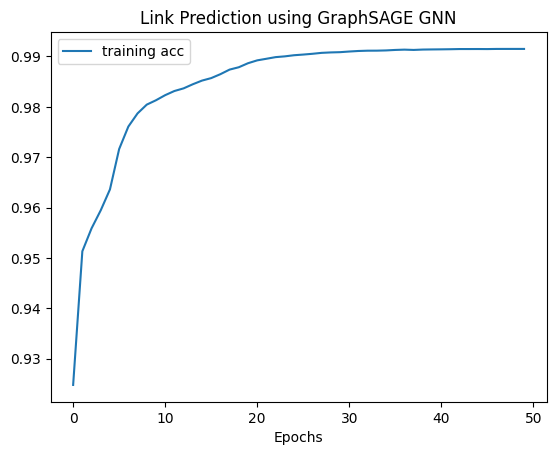

In [20]:
#Training
emb = torch.nn.Embedding(len(list(g_tmp_v.nodes)), node_emb_dim).to(device) # each node has an embedding that has to be learnt
model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device) # the MLP that takes embeddings of a pair of nodes and predicts the existence of an edge between them

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(link_predictor.parameters()) + list(emb.parameters()),
    lr=lr, weight_decay=optim_wd
)
scheduler = CosineAnnealingLR(optimizer, epochs, 1e-6)

train_acc, val_acc = [],[]
for e in range(epochs):
    loss = train(model, link_predictor, emb.weight, pos_edge_index, pos_train_edge, neg_train_edge, batch_size, optimizer)

    if (e+1)% 20 ==0:
        result_train = test(model, link_predictor, emb.weight, pos_edge_index, pos_train_edge, neg_train_edge, batch_size)
        train_acc.append(result_train)
        print(e, "training acc:", result_train)

    scheduler.step()

result = test(model, link_predictor, emb.weight, pos_edge_index, pos_valid_edge, neg_valid_edge, 1, "test")
print("validation acc: ", result)

plt.title('Link Prediction using GraphSAGE GNN')
plt.plot(train_acc,label="training acc")
# plt.plot(val_acc, label="val acc")
plt.xlabel('Epochs')
plt.legend()
plt.show()

#Generate Test CSV

In [21]:
def test_final(model, predictor, emb, pos_edge_index, test_edge, batch_size=1):
    model.eval()
    predictor.eval()

    node_emb = model(emb, pos_edge_index)

    pos_valid_preds = []
    fail = 0
    for edge_id in tqdm(range(len(test_edge))):
        pos_edge = test_edge[edge_id].T
       
        if pos_edge[0] == 30000 or pos_edge[1] == 30000:
            pos_valid_preds.append(0.5)
            fail += 1
        else:
            pos_valid_preds.append(predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]]).item())
    
    print("fail", fail)

    return pos_valid_preds

In [22]:
def write_pred(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

In [23]:
test_edge_tensor = torch.zeros(len(test_edges), 2)
fail = 0
for idx,tp in enumerate(test_edges):
  try:
    idx1, idx2 = idx_node[tp[0]], idx_node[tp[1]]
  except:
    idx1, idx2 = 30000,30000
    fail += 1
  test_edge_tensor[idx][0], test_edge_tensor[idx][1] = idx1, idx2
print(fail)
test_edge_tensor = test_edge_tensor.type(torch.int64).to(device)

result = test_final(model, link_predictor, emb.weight, pos_edge_index, test_edge_tensor)
write_pred("pred.csv", test_edges, result)

926


  0%|          | 0/40000 [00:00<?, ?it/s]<ipython-input-21-fe8005901be4>:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  pos_edge = test_edge[edge_id].T
100%|██████████| 40000/40000 [00:24<00:00, 1600.14it/s]


fail 926


#For Checking Only

In [ ]:
check_valid_pos_edges = load_data(valid_file)
check_valid_neg_edges = generate_false_edges(train_pos_edges+valid_pos_edges+check_valid_pos_edges, 40000-len(check_valid_pos_edges))

check_pos_valid_edge = torch.zeros(len(check_valid_pos_edges), 2)
check_neg_valid_edge = torch.zeros(len(check_valid_neg_edges), 2)

pos_skip = 0
neg_skip = 0
for idx,tp in enumerate(check_valid_pos_edges):
  try:
    idx1, idx2 = idx_node[tp[0]], idx_node[tp[1]]
  except:
    pos_skip += 1
    continue
  check_pos_valid_edge[idx][0], check_pos_valid_edge[idx][1] = idx1, idx2
for idx,tp in enumerate(check_valid_neg_edges):
  try:
    idx1, idx2 = idx_node[tp[0]], idx_node[tp[1]]
  except:
    neg_skip += 1
    continue
  check_neg_valid_edge[idx][0], check_neg_valid_edge[idx][1] = idx1, idx2

8485 119267


In [ ]:
check_pos_valid_edge = check_pos_valid_edge.type(torch.int64).to(device)
check_neg_valid_edge = check_neg_valid_edge.type(torch.int64).to(device)

In [ ]:
def check_test(model, predictor, emb, pos_edge_index, pos_valid_edge, neg_valid_edge, batch_size, pos_skip, neg_skip):
    model.eval()
    predictor.eval()

    node_emb = model(emb, pos_edge_index)

    pos_valid_preds = []
    pos_skip = 0
    for edge_id in DataLoader(range(pos_valid_edge.shape[0]), batch_size):
        pos_edge = pos_valid_edge[edge_id].T
        pos_valid_preds += [predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]]).squeeze().cpu()]

    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

    neg_valid_preds = []
    neg_skip = 0
    for edge_id in DataLoader(range(neg_valid_edge.shape[0]), batch_size):
        neg_edge = neg_valid_edge[edge_id].T
        neg_valid_preds += [predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]]).squeeze().cpu()]
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)
    
    y_true = [1] * len(pos_valid_pred) + [1]*pos_skip + [0] * len(neg_valid_pred) + [0]*neg_skip
    
    y_score = list(pos_valid_pred.detach().cpu().numpy()) + [0.5]*pos_skip +list(neg_valid_pred.detach().cpu().numpy()) +[0.5] * neg_skip
    
    return roc_auc_score(y_true, y_score)

In [ ]:
result = check_test(model, link_predictor, emb.weight, pos_edge_index, check_pos_valid_edge, check_neg_valid_edge, batch_size, pos_skip, neg_skip)
print(result)

0.9426496632372776


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
pos_skip

198

In [ ]:
neg_skip

748

#Visualization

In [ ]:
vectors = []
names = []
node_emb = model(emb.weight, pos_edge_index)
valid_graph = construct_graph_from_edges(valid_pos_edges)
for g in valid_graph.nodes:
  vectors.append(node_emb[idx_node[g]].detach().cpu().numpy())
  names.append(g)

number of nodes: 5391
number of edges: 19267


In [ ]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
  
X = np.array(vectors)
outs = []

for n in range(7,8):
  kmeans = KMeans(n_clusters=n, random_state=0, n_init="auto").fit(X)
  n2l = dict(zip(names, kmeans.labels_))

  out = 0
  inside = 0
  for e in valid_pos_edges:
    if e[0] in n2l and e[1] in n2l:
      if n2l[e[0]] != n2l[e[1]]:
        out += 1
      else:
        inside += 1
  print(n , out, inside)
  ss = silhouette_score(X, kmeans.labels_)
  outs.append(out)

plt.plot(range(2,20), outs, marker='o', linestyle='--', color='b', label='Square') 

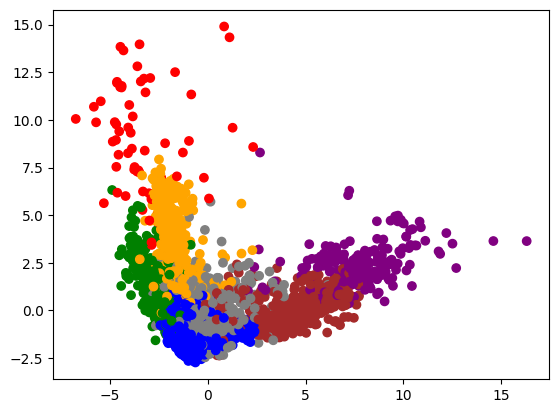

In [ ]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# pca = PCA(n_components=2)
# Xt = pca.fit_transform(X)
color_d = ['red', 'green', 'blue', 'purple', 'brown', 'gray', 'orange', 'yellow']
#color_d = ['orange', 'black', 'black', 'orange', 'brown', 'orange', 'orange', 'orange']
colors = [color_d[i] for i in kmeans.labels_]
lda = LDA(n_components=2)
Xt = lda.fit(X, kmeans.labels_).transform(X)
# Xt = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(X)

plt.scatter(Xt[:,0], Xt[:, 1], color = colors) #color = colors